In [9]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import corner
import copy as Makecopy
import time
from matplotlib import colors
import scipy as sp

from ipywidgets import IntProgress
from IPython.display import display

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

#####################################

# Objectives 

In this notebook , I simulate a single Gaussian shaped source defined by the equation:



# Generate Example Data

In [10]:
def Generate_data(m,c,x):
    """Straight line equation
    
    Parameters
    
    -------------
    
    x : list or array
        x values
        
    m: scalar
        Gradient
    
    c: scalar
        intercept
        
    --------------
    output: list or array
            *y* data values
    """
    data = m*x + c 
    return data

# Example data

In [11]:
x = np.linspace(0,20)
noise = np.random.normal(0,5,len(x))
Data = Generate_data(4,3,x) + noise

Text(0,0.5,'y')

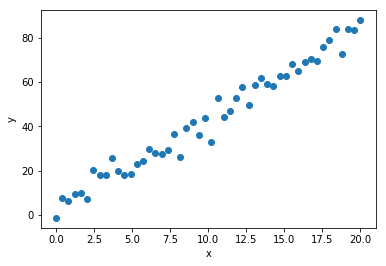

In [12]:
plt.plot(x,Data,'o')
plt.xlabel('x')
plt.ylabel('y')

# Model Equation

Straight Line : $$y = mx + c$$

In [13]:
def Model(theta,x):
    """Straight Line Equation
    
    Parameters
    ------------
    
    theta: list or array
            parameters [m.c], gradient m and intercept c
    
    x : list or array
        x values
    
    """
    m,c = theta
    y = m*x + c
    return y

# Prior of M and C.

I used a gaussian prior on each parameter ( gradient m and intercept c)

In [14]:
def LogPrior(theta):
    """ Log prior probability of m and c.
    
    Paramter
    -------------
    m : scalar
        Gradient
        
    c: scalar
        intercept
    
    ------------
    
    Output: scalar
            log-prior
     """
    m,c = theta
    P_m = stats.norm.pdf(m, loc=5, scale=1)
    P_c = stats.norm.pdf(c, loc=4, scale=1)
    
    return np.log(P_c) + np.log(P_m)

# Likelihood function

TODO: I define a Gaussian log-likelihood function given by;

$$\log{L} = \sum_{i}^{n}{\log{\frac{1}{\sqrt{2\pi\sigma_{i}^{2}}}}} + \sum_{i}^{n}{-\frac{(data - model)^{2}}{2\sigma_{i}^{2}}}$$

In [15]:
def LogL(theta,x,data,sigmay):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values are
    *y = m * x + b*

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    c: scalar line intercept

    Returns: scalar log likelihood
    '''
    y = data
    model = Model(theta,x)
    logL = (np.sum(np.log(1./(np.sqrt((2.*np.pi)*sigmay**2)))) +
            np.sum(-0.5 * (y - model)**2 / sigmay**2))
    return logL

# Posterior

In [16]:
def LogPosterior(theta,x,data,sigmay):
    """
    Evaluates the log Posterior  of the gradient m and intercept c
    
    Parameters
    
    --------------
    
    theta : list or array
            parameters m,c
                
    data: list or array 
            data values
            
    sigmay:  list or array 
            Data noise
    ---------------
    
    output: scalar
            Log-Posterior
    """
    logP = LogL(theta,x,data,sigmay) + LogPrior(theta)
    return logP

# Metropolis-Hasting

In [17]:
def metropolis(log_posterior,theta,data,sigmay,stepsize, nsteps):
    
    ''' Metropolis Hasting
    
    Parameters
    
    ------------------
    
    log_posterior: function 
                    log posterior function
                    
    stepsize:      list or array 
                    vector proposal distribution width
    
    nsteps:     scalar
                number of samples
                
    -------------------
    
    Output: array,array and scalar
            
            samples,log probability of samples, acceptance ratio
    '''
    
    log_prob = log_posterior(theta,x,data,sigmay)
    
    # Store Markov chain as an array of samples:
    chain = np.empty((nsteps, len(theta)))
    log_probs = np.empty(nsteps)
    
    # Count accepted proposals:
    naccept = 0
    
    for i in range(nsteps): # Accept proposed sample
        theta_new = theta + stepsize * np.random.randn(len(theta))
        log_prob_new = log_posterior(theta_new,x,data, sigmay)
        
        if (log_prob_new-log_prob) > np.log(np.random.rand()):
            
            theta = theta_new
            log_prob = log_prob_new
            naccept += 1
            
        else: # Reject proposed sample
            theta = theta
            
        chain[i] = theta         #record current point
        log_probs[i] = log_prob  #record loglikelihood of current point
        
    acceptance_rate = naccept/float(nsteps)  # acceptance ration
    
    return chain,log_probs,acceptance_rate

# Initialize MCMC

In [18]:
#number of mcmc steps 
nsteps = 100000

#mcmc s5tepsize
mstep , cstep = 0.02,0.03
stepsize = np.array([mstep,cstep])


#mcmc initial points
m = 2
b = 2
theta = np.array([m,b])


# data and noise
data = Data
sigmay = noise

# Run MCMC

In [20]:
Chain , Log_probs , Acceptance  = metropolis(LogPosterior,theta,data,sigmay,stepsize,nsteps)

print('Acceptance ratio : ',Acceptance)

Acceptance ratio :  0.60269


Text(0,0.5,'Intercept c')

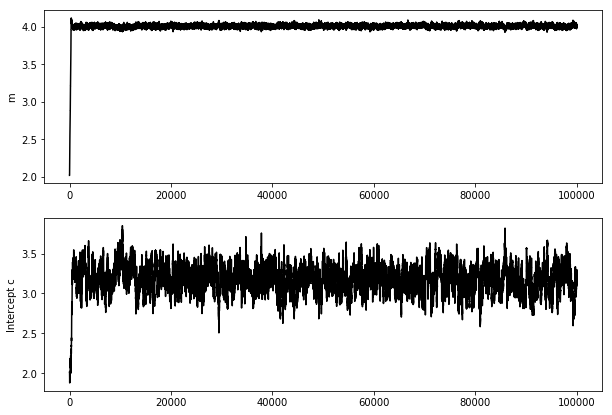

In [21]:
# Pull m and b arrays out of the Markov chain and plot them:
mm = [m for m,c in Chain]
cc = [c for m,c in Chain]

# Traces, for convergence inspection:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(mm, 'k-')
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(cc, 'k-')
plt.ylabel('Intercept c')


In [22]:
Mean_m = np.mean(mm)
Mean_c = np.mean(cc)

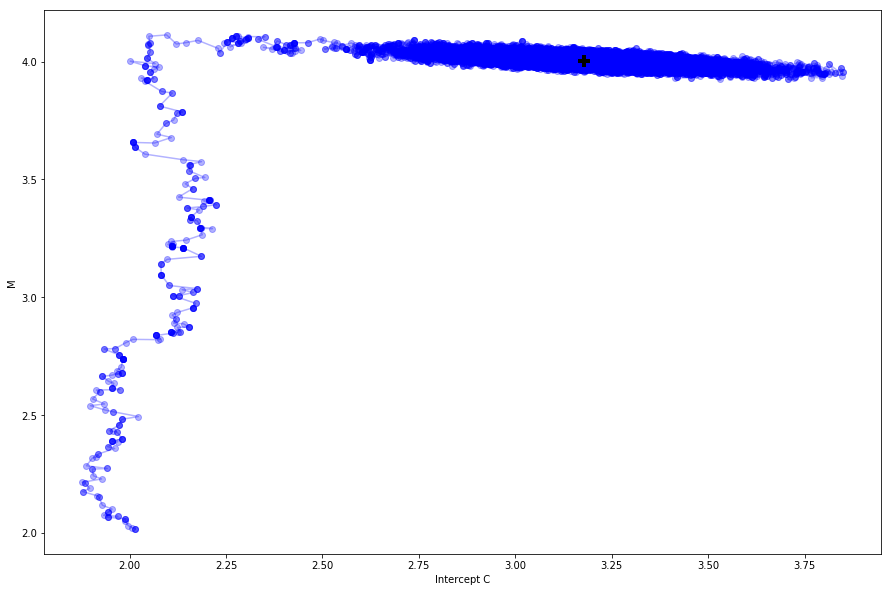

In [23]:
plt.figure(figsize=(15,10))
plt.plot(cc, mm, 'bo-', alpha=0.3)
plt.xlabel('Intercept C')
plt.ylabel('M')

plt.plot(Mean_c,Mean_m,'k+',ms=12, mew=4)

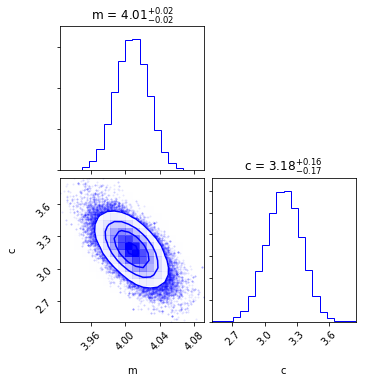

In [24]:
import corner
corner.corner(Chain[5000:], labels=['m','c'],show_titles=True,color='b',smooth=1.0);

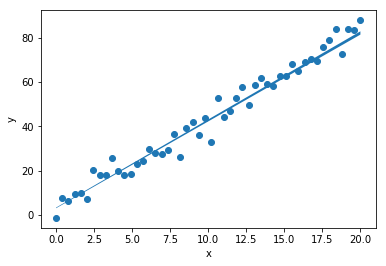

In [25]:
plt.plot(x,Data,'o')
plt.xlabel('x')
plt.ylabel('y')

y = 3.94*x+3.125
merr = 0.03
cerr = 0.14

y1 = (3.94+merr)*x + (3.25+cerr)
y2 = (3.94-merr)*x + (3.25-cerr)
 

plt.fill_between(x,y1,y2)


# Exploit the fact that in Z = Sum Liwi where wi is the change in prior mass.  equation 7 (John Skilling 2004)

In [26]:
for i in range(0, nsteps):
    logX = -(np.arange(0, i+1) + 1.)/nsteps

In [27]:
logwt = logX.copy() + Log_probs
wt = np.exp(logwt - logwt.max())

In [28]:
def logsumexp(values):
    biggest = np.max(values)
    x = values - biggest
    result = np.log(np.sum(np.exp(x))) + biggest
    return result

# Prior weights
logw = logX.copy()
# Normalise them
logw -= logsumexp(logw)

# Calculate marginal likelihood
logZ = logsumexp(logw + Log_probs)


In [29]:
logZ

-116.19305842850937

# Nested Sampling

In [23]:
import copy as duplicate

# Generate Walkers

In [66]:
def Get_particles_from_prior():
    m = sp.stats.uniform.rvs(0,20)
    c = sp.stats.uniform.rvs(0,20)
    
    theta = [m,c]
    return theta

In [134]:
#Generate walkers

#Number of walkers
N = 60

particles = []
logp = np.empty(N)
logl = np.empty(N)

for i in range(0, N):
    theta = Get_particles_from_prior()
    particles.append(theta)
    logl[i] = LogL(theta,x,data,sigmay)
    logp[i] = LogPrior(theta)

# Initialize

In [135]:
# Number of NS iterations
nest_steps = 1400

# MCMC steps per NS iteration
mcmc_steps = 60

#Number of parameters
num_params = 2

# Storage for results
keep = np.empty((nest_steps, num_params + 1))
nacceptance = np.zeros(nest_steps)
nrejectance = np.zeros(nest_steps)

# Main Nest

In [136]:

for i in range(nest_steps):
    
    worst = np.argmin(logl)   # Particle with worst likelihood
    
    keep[i,:-1] = particles[worst] # Save the details of the particle , (m,c) and (likelihood)
    keep[i,-1] = logl[worst]
    
    # Copy random survivor
    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(particles))
        if (copy != worst):break
            
    particles[worst] = duplicate.deepcopy(particles[copy]) # No user shall override
    
    logl_threshold = duplicate.deepcopy(logl[worst])
    
    naccept = 0
    nreject = 0
    for mcmci in range(mcmc_steps):
        theta_new = particles[worst] + stepsize * np.random.randn(len(theta))
        logl_new = LogL(theta_new,x,data,sigmay)
        
        logp_new = LogPrior(theta_new)
        
        if (logl_new>logl_threshold) and (logp_new-logp[worst])>=np.log(np.random.rand()):
            particles[worst] = theta_new
            logp[worst] = logp_new
            logl[worst] = logl_new
            
            naccept += 1 
            
        else:
            particles[worst] = particles[worst]
            nreject += 1
    
    nacceptance[i] = naccept/mcmc_steps



#Prior Mass    
logX = -(np.arange(0, (nest_steps)) + 1.)/N


Text(0,0.5,'Acceptance Ratiio')

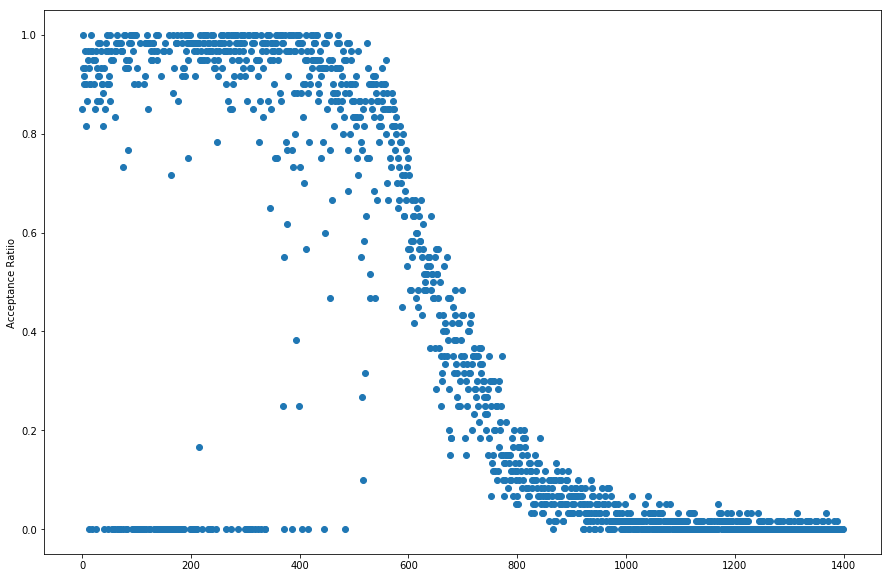

In [137]:
plt.figure(figsize=(15,10))
plt.plot(nacceptance,'o')
plt.ylabel('Acceptance Ratiio')

Text(0.5,0,'$\\log(X)$')

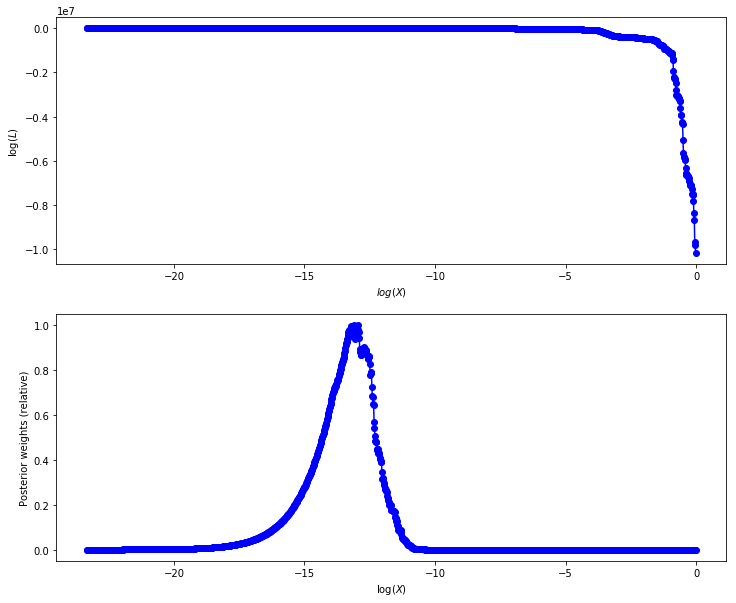

In [138]:
#Visualize Likelihood vs Prior Mass

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(logX, keep[0:(nest_steps), -1], 'bo-')
plt.ylabel('$\\log(L)$')
plt.xlabel('$log(X)$')



plt.subplot(2,1,2)
#Posterior weights
logwt = logX.copy() + keep[0:(nest_steps), -1]
wt = np.exp(logwt - logwt.max())
plt.plot(logX, wt, 'bo-')
plt.ylabel('Posterior weights (relative)')
plt.xlabel('$\\log(X)$')

In [139]:
# Useful function #Compute the log of the sum of exponentials of input elements.
# OR from scipy.misc import logsumexp 

def logsumexp(values):
    biggest = np.max(values)
    x = values - biggest
    result = np.log(np.sum(np.exp(x))) + biggest
    return result



# Prior weights
logw = logX.copy()
# Normalise them
logw -= logsumexp(logw)  

# Calculate marginal likelihood
logZ = logsumexp(logw + keep[:,-1])


In [140]:
# Normalised posterior weights
wt = wt/wt.sum()

effective_sample_size = int(np.exp(-np.sum(wt*np.log(wt + 1E-300))))

# Calculate information
H = np.sum(wt*(keep[:,-1] - logZ))

print('logZ = {logZ} '.format(logZ=logZ))
print('Information = {H}'.format(H=H))
print('Effective Sample Size = {ess}'.format(ess=effective_sample_size))

logZ = -125.62993013794804 
Information = 12.02432353032746
Effective Sample Size = 283


# Computing the error on LogZ

# Compute the weighted Posterior results

In [141]:
posterior_samples = np.empty((effective_sample_size, keep.shape[1]))
k = 0
while True:
  # Choose one of the samples
    which = np.random.randint(keep.shape[0])

  # Acceptance probability
    prob = wt[which]/wt.max()

    if np.random.rand() <= prob:
        posterior_samples[k, :] = keep[which, :]
        k += 1

    if k >= effective_sample_size:
        break

np.savetxt('keep.txt', posterior_samples)

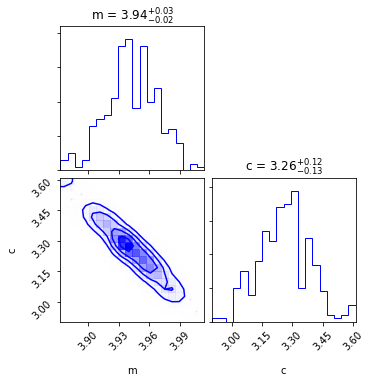

In [142]:
corner.corner(posterior_samples[:,:-1], labels=['m','c'],show_titles=True,color='b',smooth=1.0);

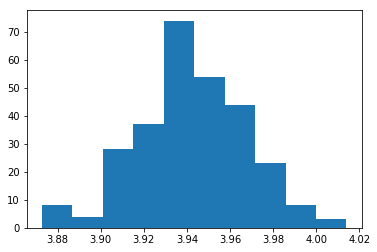

In [143]:
plt.hist(posterior_samples[:,0]);

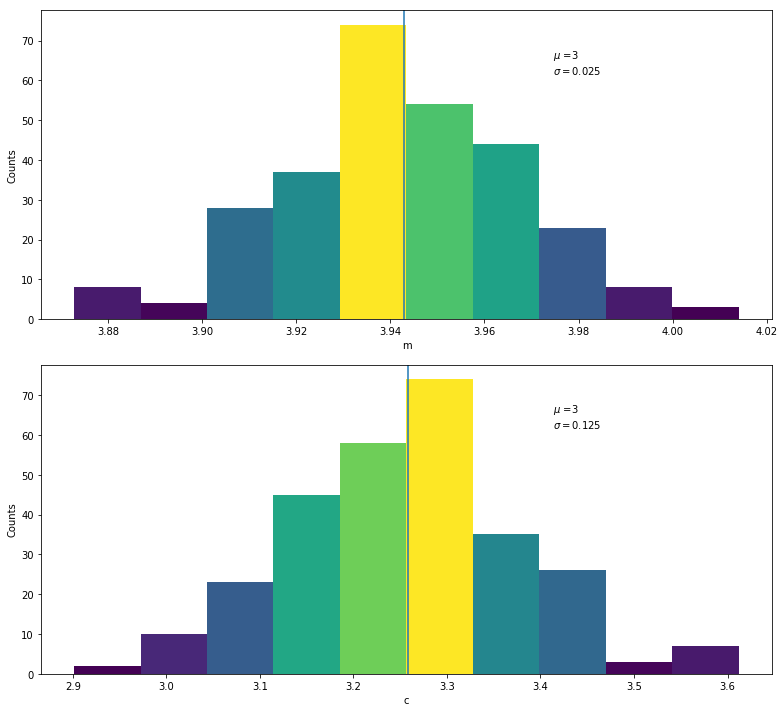

In [144]:
fig = plt.figure(figsize=(11,10))

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

Labels = ['m','c']
for L,num in zip(Labels, range(0,2)):
    
    ax = fig.add_subplot(2,1,num+1)
    N, bins, patches = ax.hist(posterior_samples[:,num])
    
    fracs = N.astype(float) / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
    norm = colors.Normalize(fracs.min(), fracs.max())

    mean = np.mean(posterior_samples[:,num])
    sigma = np.std(posterior_samples[:,num])
    
    
    
    ax.annotate("$\mu$"+" ="+str(int(mean)) +'\n'+'$\sigma =$'+str(round(sigma,3)), xy=(0.7, 0.8), xycoords="axes fraction")

    
# Now, we'll loop through our objects and set the color of each accordingly
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    ax.set_xlabel(L)
    ax.set_ylabel('Counts')
    ax.axvline(mean)
    
plt.tight_layout()

# Run mcmc on this

In [ ]:
e_index = np.array([1.5,1.7,1.8,1.9,2,2.2,2.3]) # x_data
nu = np.array([4e-03,1e-02,1e-02,8e-03,2e-02,1e-02,3e-02]) # y_data

In [ ]:
yerr = np.random.normal(0,.0001,len(e_index))

nu_new = nu +yerr

plt.plot(e_index,nu_new,'o')

In [ ]:
def sinosoid(theta,x):
    a,b,c = theta
    sino = a*np.sin(2*np.pi*x+b) + c
    return sino

In [ ]:
def poly(theta,x):
    poly = sin(2*pi*t)
    
    a,b,c = theta
    poly = a*x**2 + b*x + c
    return poly

In [ ]:
def LogPrior_poly(theta,theta_limits):
    a,b,c = theta
    alimits,blimits,climits = theta_limits
    # Uniform in m:
    if (a < alimits[0]) | (a > alimits[1]):
        log_a_prior = -np.inf
    else:
        log_a_prior = np.log(1.0/(alimits[1] - alimits[0]))
    # Uniform in b:
    if (b < blimits[0]) | (b > blimits[1]):
        log_b_prior = -np.inf
    else:
        log_b_prior = np.log(1.0/(blimits[1] - blimits[0]))
        
        # Uniform in c:
    if (c < climits[0]) | (c > climits[1]):
        log_c_prior = -np.inf
    else:
        log_c_prior = np.log(1.0/(climits[1] - climits[0]))
        
    return log_a_prior + log_b_prior + log_c_prior

In [ ]:
def LogPosterior_poly(theta,x,data,sigmay,theta_limits):
    logP = LogL_poly(theta,x,data,sigmay) + LogPrior_poly(theta,theta_limits)
    return logP

In [ ]:
def LogL_poly(theta,x,data,sigmay_poly):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values are
    *y = m * x + b*

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    c: scalar line intercept

    Returns: scalar log likelihood
    '''
    y = data
    model_poly = sinosoid(theta,x)
    logL = (np.sum(np.log(1./(np.sqrt((2.*np.pi)*sigmay_poly**2)))) +
            np.sum(-0.5 * (y - model_poly)**2 / sigmay_poly**2))
    return logL

In [ ]:
nsteps = 1000000
astep , bstep , cstep = 0.0001,0.0006,0.00005
stepsize_poly = np.array([astep,bstep,cstep])


alimits = [-0.5, .0005]
blimits = [-.05,.005]
climits = [-.05,.005]
theta_limits = (alimits, blimits,climits)


a =  0.8*(alimits[0]+alimits[1])
b =  0.8*(blimits[0]+blimits[1])
c =  .7*(climits[0]+climits[1])

theta_poly = np.array([a,b,c])
x_poly = e_index        #np.linspace(0,3,len(data_poly))
data_poly = nu
sigmay_poly = yerr

In [ ]:
Chain_poly , Log_probs_poly , Acceptance_poly  = metropolis(LogPosterior_poly,theta_poly,x_poly,data_poly,
                                                            theta_limits,sigmay_poly,stepsize_poly,nsteps)

print(Acceptance_poly)

In [ ]:
# Pull m and b arrays out of the Markov chain and plot them:
aa = [a for a,b,c in Chain_poly]
bb = [b for a,b,c in Chain_poly]
cc = [c for a,b,c in Chain_poly]

# Traces, for convergence inspection:
plt.figure(figsize=(10,7))
plt.subplot(3,1,1)
plt.plot(aa, 'k-')
plt.ylabel('a')

plt.subplot(3,1,2)
plt.plot(bb, 'k-')
plt.ylabel('b')

plt.subplot(3,1,3)
plt.plot(cc, 'k-')
plt.ylabel('c')

In [ ]:
import corner
corner.corner(Chain_poly, labels=['a','b','c'],show_titles=True,color='b',smooth=1.0);

In [ ]:
plt.plot(e_index,nu_new,'o')
plt.xlabel('x')
plt.ylabel('y')


a_mean = np.mean(aa)
b_mean = np.mean(bb)
c_mean = np.mean(bb)

params = np.array([a_mean,b_mean,c_mean])

#plt.plot(e_index,poly([a_mean,b_mean,c_mean],e_index))

plt.plot(e_index,sinosoid(params,e_index))